In [77]:
import math

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, LeaveOneOut

%matplotlib inline
sns.set_style('white')

We'll use the property crime model you've been working on with, based on the FBI:UCR data. Since your model formulation to date has used the entire New York State 2013 dataset, you'll need to validate it using some of the other crime datasets available at the FBI:UCR website. Options include other states crime rates in 2013 or crime rates in New York State in other years or a combination of these.

Iterate
Based on the results of your validation test, create a revised model, and then test both old and new models on a new holdout or set of folds. In this case, your goal is to achieve a model with a consistent R2 and only statistically significant parameters across multiple samples.

Include your model(s) and a brief writeup of the reasoning behind the validation method you chose and the changes you made to submit and review with your mentor.

https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table_8_offenses_known_to_law_enforcement_by_state_by_city_2013.xls/view

https://ucr.fbi.gov/crime-in-the-u.s/2014/crime-in-the-u.s.-2014/tables/table-8/table-8-by-state/Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls

In [2]:
df = pd.read_csv('copieddata.csv')
#rename columns to be programmer friendly
df.columns = ['city', 'population', 'violent_crime',
       'murder_and_nonnegligent_manslaughter',
       'rape_revised', 'rape_legacy',
       'robbery', 'agg_assault', 'property_crime', 'burglary',
       'larceny_theft', 'motor_vehicle_theft', 'arson']
df.head()

,city,population,violent_crime,murder_and_nonnegligent_manslaughter,rape_revised,rape_legacy,robbery,agg_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson
0,Adams Village,"1,861",0,0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,"2,577",3,0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,"2,846",3,0,NaN,0,0,3,16,1,15,0,0.0
3,Albany,"97,956",791,8,NaN,30,227,526,"4,090",705,"3,243",142,NaN
4,Albion Village,"6,388",23,0,NaN,3,4,16,223,53,165,5,NaN


In [3]:
#convert to appropriate types
df['population'] = df.population.str.replace(',', '').astype('float')
df['violent_crime'] = df.violent_crime.str.replace(',', '').astype('float')
df['murder_and_nonnegligent_manslaughter'] = df.murder_and_nonnegligent_manslaughter.astype('float')
df.drop(columns=['rape_revised'], inplace=True)
df['rape_legacy'] = df.rape_legacy.str.replace(',', '').astype('float')
df['robbery'] = df.robbery.str.replace(',', '').astype('float')
df['agg_assault'] = df.agg_assault.str.replace(',', '').astype('float')
df['property_crime'] = df.property_crime.str.replace(',', '').astype('float')
df['burglary'] = df.burglary.str.replace(',', '').astype('float')
df['larceny_theft'] = df.larceny_theft.str.replace(',', '').astype('float')
df['motor_vehicle_theft'] = df.motor_vehicle_theft.str.replace(',', '').astype('float')

In [4]:
#Remove NYC, which is way too big to put into the same model as the rest of this data

dfny = df[df.city != 'New York']
dfny.shape

(347, 12)

In [5]:
#Use PCA on several crime items to predict property crime
crimelist = dfny[['violent_crime', 'murder_and_nonnegligent_manslaughter', 'rape_legacy', 'robbery', 'agg_assault', 'burglary'
             , 'larceny_theft', 'motor_vehicle_theft']]
S = StandardScaler().fit_transform(crimelist)

St = S.T
Cx = np.cov(St)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 8).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)




Eigenvector 1: 
[[-0.35820137]
 [-0.34985744]
 [-0.35307405]
 [-0.35643112]
 [-0.35590089]
 [-0.35699338]
 [-0.34006579]
 [-0.35753695]]
Eigenvalue 1: 7.702914656761019
----------------------------------------
Eigenvector 2: 
[[ 0.20266952]
 [ 0.27941353]
 [-0.09578768]
 [ 0.30607455]
 [ 0.14667777]
 [-0.18870679]
 [-0.83564497]
 [ 0.15023018]]
Eigenvalue 2: 0.1503854306337862
----------------------------------------
Eigenvector 3: 
[[ 0.31098501]
 [-0.71040826]
 [-0.29431104]
 [ 0.19724078]
 [ 0.47104158]
 [-0.18008459]
 [ 0.0863402 ]
 [ 0.10639665]]
Eigenvalue 3: 0.07642452603034493
----------------------------------------
Eigenvector 4: 
[[ 0.01686911]
 [-0.36547888]
 [ 0.80593643]
 [-0.25825434]
 [ 0.16475505]
 [ 0.0718532 ]
 [-0.31624186]
 [-0.13264906]]
Eigenvalue 4: 0.050654478915381135
----------------------------------------
Eigenvector 5: 
[[-8.27763984e-01]
 [ 1.29658548e-02]
 [ 3.75676081e-02]
 [ 3.32174169e-01]
 [ 4.50430538e-01]
 [-4.25702367e-14]
 [ 8.63195463e-15]
 [ 7.

In [6]:
#96% explained by the first component. Easily keep that one and toss the rest.
P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(St)

#create a new df with the outcome variable and add Y as a feature
features = pd.DataFrame(dfny['property_crime'])

features['crime'] = Y

#Add the root of population, which was also useful per the last assignment
features['sqrtpop'] = [math.sqrt(x) for x in dfny['population']]

features.head()

,property_crime,crime,sqrtpop
0,12.0,0.682761,43.139309
1,24.0,0.658510,50.764161
2,16.0,0.668880,53.347915
3,4090.0,-7.807937,312.979233
4,223.0,0.320755,79.924965


In [7]:
linear_formula = 'property_crime ~ crime+sqrtpop'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=features).fit()
lm.params

Intercept     76.705909
crime       -311.726328
sqrtpop        2.951195
dtype: float64

In [8]:
lm.pvalues

Intercept     1.211392e-03
crime        1.118961e-186
sqrtpop       1.938859e-38
dtype: float64

In [9]:
lm.rsquared

0.9636910242031071

In [10]:
lm.conf_int()

,0,1
Intercept,30.474102,122.937716
crime,-321.767847,-301.684810
sqrtpop,2.557261,3.345129


In [11]:
#Duplicate the model using sklearn


regr = linear_model.LinearRegression()
Y = features['property_crime']
X = features[['crime','sqrtpop']]
regr.fit(X, Y)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
print('\nMean Squared Error:')
features['ypred'] = regr.predict(X).ravel()

print(mean_squared_error(features['property_crime'],features.ypred))


Coefficients: 
 [-311.72632834    2.95119523]

Intercept: 
 76.7059091067336

R-squared:
0.9636910242031071

Mean Squared Error:
38735.72383066401


# Load testing data

In [12]:
#Another state, same year
vt = pd.read_csv('vermont.csv')
vt.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson
0,Barre Town,"7,932",2,0,0,NaN,0,2,162,51,107,4,0
1,Bennington,"15,492",31,0,4,NaN,2,25,477,128,327,22,4
2,Berlin,"2,867",13,0,1,NaN,1,11,143,13,125,5,0
3,Bradford,"2,777",1,0,0,NaN,1,0,64,8,55,1,0
4,Brattleboro,"11,784",36,0,4,NaN,7,25,606,98,490,18,0


In [13]:
#rename columns to be programmer friendly
vt.columns = ['city', 'population', 'violent_crime',
       'murder_and_nonnegligent_manslaughter',
       'rape_revised', 'rape_legacy',
       'robbery', 'agg_assault', 'property_crime', 'burglary',
       'larceny_theft', 'motor_vehicle_theft', 'arson']


#convert to appropriate types
vt['population'] = vt.population.str.replace(',', '').astype('float')
vt.drop(columns=['rape_legacy'], inplace=True)
vt['property_crime'] = vt.property_crime.str.replace(',', '').astype('float')
vt.dtypes

city                                     object
population                              float64
violent_crime                             int64
murder_and_nonnegligent_manslaughter      int64
rape_revised                              int64
robbery                                   int64
agg_assault                               int64
property_crime                          float64
burglary                                  int64
larceny_theft                             int64
motor_vehicle_theft                       int64
arson                                     int64
dtype: object

In [14]:
print(vt.shape)
vt.head()

(35, 12)


,city,population,violent_crime,murder_and_nonnegligent_manslaughter,rape_revised,robbery,agg_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson
0,Barre Town,7932.0,2,0,0,0,2,162.0,51,107,4,0
1,Bennington,15492.0,31,0,4,2,25,477.0,128,327,22,4
2,Berlin,2867.0,13,0,1,1,11,143.0,13,125,5,0
3,Bradford,2777.0,1,0,0,1,0,64.0,8,55,1,0
4,Brattleboro,11784.0,36,0,4,7,25,606.0,98,490,18,0


# Testing the original model on the Vermont data

In [15]:
#Use PCA on several crime items to predict property crime
vtcrime = vt[['violent_crime', 'murder_and_nonnegligent_manslaughter', 'rape_revised', 'robbery', 'agg_assault', 'burglary'
             , 'larceny_theft', 'motor_vehicle_theft']]
S = StandardScaler().fit_transform(vtcrime)

St = S.T
Cx = np.cov(St)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 8).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)




Eigenvector 1: 
[[0.40775019]
 [0.11599093]
 [0.29394276]
 [0.35250166]
 [0.39139691]
 [0.3971787 ]
 [0.39418376]
 [0.37855359]]
Eigenvalue 1: 5.953573841653903
----------------------------------------
Eigenvector 2: 
[[-0.10384367]
 [ 0.8844279 ]
 [-0.09153697]
 [ 0.36650601]
 [-0.21098768]
 [-0.02103309]
 [-0.06216623]
 [-0.12439969]]
Eigenvalue 2: 1.159432675699303
----------------------------------------
Eigenvector 3: 
[[ 0.0194434 ]
 [ 0.10073591]
 [ 0.9316815 ]
 [-0.1585965 ]
 [-0.10828148]
 [-0.15992841]
 [-0.19508283]
 [-0.14467785]]
Eigenvalue 3: 0.5770283413092461
----------------------------------------
Eigenvector 4: 
[[ 0.11061399]
 [ 0.32917968]
 [-0.10455676]
 [-0.51406703]
 [ 0.25591938]
 [-0.08624395]
 [-0.41576062]
 [ 0.59868073]]
Eigenvalue 4: 0.23151472092096723
----------------------------------------
Eigenvector 5: 
[[-7.74702729e-01]
 [ 1.41193491e-02]
 [ 1.06796914e-01]
 [ 1.24553294e-01]
 [ 6.10505710e-01]
 [ 2.59167797e-15]
 [-2.44776359e-15]
 [-1.64946175e-1

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [16]:
#96% explained by the first component. Easily keep that one and toss the rest.
P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(St)

#create a new df with the outcome variable and add Y as a feature
vtfeatures = pd.DataFrame(vt['property_crime'])

vtfeatures['crime'] = Y

#Add the root of population, which was also useful per the last assignment
vtfeatures['sqrtpop'] = [math.sqrt(x) for x in vt['population']]

vtfeatures.head()

,property_crime,crime,sqrtpop
0,162.0,-0.696486,89.061776
1,477.0,4.560532,124.466863
2,143.0,0.091671,53.544374
3,64.0,-1.363357,52.697249
4,606.0,5.450407,108.554134


In [17]:
lm.rsquared

0.9636910242031071

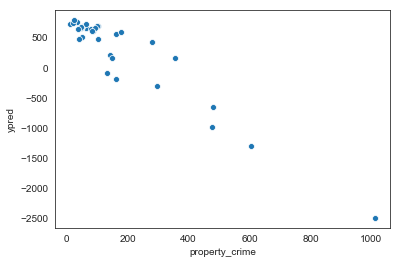

In [18]:
vtfeatures['ypred'] = lm.predict(exog={"crime": vtfeatures.crime, "sqrtpop": vtfeatures.sqrtpop})
sns.scatterplot(vtfeatures.property_crime, vtfeatures.ypred)

In [19]:
#Duplicate the model using sklearn

#Attempt 1
regr = linear_model.LinearRegression()
Y = features['property_crime']
X = features[['crime','sqrtpop']]
regr.fit(X, Y)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))




Coefficients: 
 [-311.72632834    2.95119523]

Intercept: 
 76.7059091067336

R-squared:
0.9636910242031071


In [20]:
#Score on the vermont data
print('\nR-squared:')
print(regr.score(vtfeatures[['crime','sqrtpop']], vtfeatures['property_crime']))
print('\nMean Squared Error:')
print(mean_squared_error(vtfeatures.property_crime,vtfeatures.ypred))


R-squared:
-18.670920144815298

Mean Squared Error:
806163.1877638529


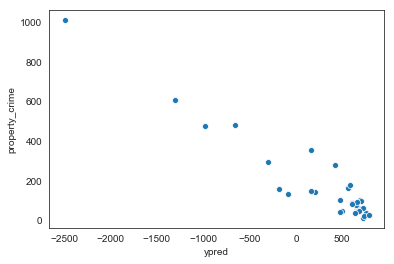

In [21]:
#Basically this data is working terrible for vermont
sns.scatterplot(vtfeatures.ypred,vtfeatures.property_crime)
plt.show()

In [22]:
#
#New York, different year
dftest = pd.read_csv('nytest.csv')
dftest.dtypes

City                                       object
Population                                 object
Violent\ncrime                             object
Murder and\nnonnegligent\nmanslaughter      int64
Rape\n(revised\ndefinition)1               object
Rape\n(legacy\ndefinition)2               float64
Robbery                                    object
Aggravated\nassault                        object
Property\ncrime                            object
Burglary                                   object
Larceny-\ntheft                            object
Motor\nvehicle\ntheft                      object
Arson3                                    float64
dtype: object

In [23]:
dftest.columns = ['city', 'population', 'violent_crime',
       'murder_and_nonnegligent_manslaughter',
       'rape_revised', 'rape_legacy',
       'robbery', 'agg_assault', 'property_crime', 'burglary',
       'larceny_theft', 'motor_vehicle_theft', 'arson']




#convert to appropriate types
dftest['population'] = dftest.population.str.replace(',', '').astype('float')
dftest['violent_crime'] = dftest.violent_crime.str.replace(',', '').astype('float')

dftest['rape_revised'] = dftest.rape_revised.str.replace(',', '').astype('float')
dftest['robbery'] = dftest.robbery.str.replace(',', '').astype('float')
dftest['agg_assault'] = dftest.agg_assault.str.replace(',', '').astype('float')
dftest['property_crime'] = dftest.property_crime.str.replace(',', '').astype('float')
dftest['burglary'] = dftest.burglary.str.replace(',', '').astype('float')
dftest['larceny_theft'] = dftest.larceny_theft.str.replace(',', '').astype('float')
dftest['motor_vehicle_theft'] = dftest.motor_vehicle_theft.str.replace(',', '').astype('float')

print(dftest.shape)
dftest

(369, 13)


,city,population,violent_crime,murder_and_nonnegligent_manslaughter,rape_revised,rape_legacy,robbery,agg_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson
0,Adams Village,1851.0,0.0,0,NaN,0.0,0.0,0.0,11.0,1.0,10.0,0.0,0.0
1,Addison Town and Village,2568.0,2.0,0,NaN,0.0,1.0,1.0,49.0,1.0,47.0,1.0,0.0
2,Afton Village4,820.0,0.0,0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,Akron Village,2842.0,1.0,0,NaN,0.0,0.0,1.0,17.0,0.0,17.0,0.0,0.0
4,Albany4,98595.0,802.0,8,54.0,NaN,237.0,503.0,3888.0,683.0,3083.0,122.0,12.0
5,Albion Village4,5872.0,26.0,0,3.0,NaN,2.0,21.0,204.0,41.0,159.0,4.0,0.0
6,Alexandria Bay Village4,1107.0,0.0,0,0.0,NaN,0.0,0.0,7.0,2.0,5.0,0.0,0.0
7,Alfred Village4,4032.0,11.0,1,1.0,NaN,0.0,9.0,30.0,6.0,24.0,0.0,0.0
8,Altamont Village4,1723.0,1.0,0,0.0,NaN,0.0,1.0,2.0,2.0,0.0,0.0,0.0
9,Amherst Town4,118860.0,128.0,1,16.0,NaN,43.0,68.0,2066.0,176.0,1846.0,44.0,2.0


In [24]:
#drop NYC
dftest = dftest[dftest.city != 'New York4']
#drop rows where outcome variable is unknown
dftest = dftest[dftest['property_crime'].notna()]

dftest.shape

(367, 13)

In [25]:
#create the features
#First, I need to add the rape columns together. none of them have a value in both, and all have at least one, so it's 
#not a perfect imputation but it suffices

dftest['rape'] = dftest['rape_legacy'].fillna(value=0) + dftest['rape_revised'].fillna(value=0) 
#Larceny has 1 NAN, which I'll impute with a zero since it's a small city
dftest['larceny_theft'] = dftest['larceny_theft'].fillna(value=0) 

dftest.head()

,city,population,violent_crime,murder_and_nonnegligent_manslaughter,rape_revised,rape_legacy,robbery,agg_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson,rape
0,Adams Village,1851.0,0.0,0,NaN,0.0,0.0,0.0,11.0,1.0,10.0,0.0,0.0,0.0
1,Addison Town and Village,2568.0,2.0,0,NaN,0.0,1.0,1.0,49.0,1.0,47.0,1.0,0.0,0.0
2,Afton Village4,820.0,0.0,0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,Akron Village,2842.0,1.0,0,NaN,0.0,0.0,1.0,17.0,0.0,17.0,0.0,0.0,0.0
4,Albany4,98595.0,802.0,8,54.0,NaN,237.0,503.0,3888.0,683.0,3083.0,122.0,12.0,54.0


In [26]:
nytestcrime = dftest[['violent_crime', 'murder_and_nonnegligent_manslaughter', 'rape', 'robbery', 'agg_assault', 'burglary'
             , 'larceny_theft', 'motor_vehicle_theft']]

In [27]:
S = StandardScaler().fit_transform(nytestcrime)
St = S.T
Cx = np.cov(St)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 8).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[[-0.36019561]
 [-0.34976969]
 [-0.34060458]
 [-0.35831949]
 [-0.35660932]
 [-0.36012304]
 [-0.34307208]
 [-0.35910818]]
Eigenvalue 1: 7.598659189683636
----------------------------------------
Eigenvector 2: 
[[ 0.16877888]
 [ 0.42869818]
 [-0.6085361 ]
 [ 0.29606816]
 [ 0.16805571]
 [-0.0995305 ]
 [-0.52441335]
 [ 0.12884341]]
Eigenvalue 2: 0.2100395111758887
----------------------------------------
Eigenvector 3: 
[[-0.10714331]
 [ 0.11275771]
 [-0.65630352]
 [-0.09188377]
 [-0.04987116]
 [ 0.10812569]
 [ 0.7218735 ]
 [-0.03673441]]
Eigenvalue 3: 0.09366286106431679
----------------------------------------
Eigenvector 4: 
[[-0.35924719]
 [ 0.59501014]
 [ 0.16570556]
 [-0.1494794 ]
 [-0.60277936]
 [ 0.1812337 ]
 [-0.07035469]
 [ 0.25683375]]
Eigenvalue 4: 0.07482791909159463
----------------------------------------
Eigenvector 5: 
[[-0.05714506]
 [-0.49975412]
 [-0.14149515]
 [ 0.28177568]
 [-0.27576718]
 [-0.08830578]
 [ 0.00918316]
 [ 0.75075434]]
Eigenvalue 5: 0.02

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [28]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(St)

#create a new df with the outcome variable and add Y as a feature
nyfeatures = pd.DataFrame(dftest['property_crime'])

nyfeatures['crime'] = Y

#Add the root of population, which was also useful per the last assignment
nyfeatures['sqrtpop'] = [math.sqrt(x) for x in dftest['population']]



R-squared:
0.9554933026080367

Mean Squared Error:
40735.879775902366


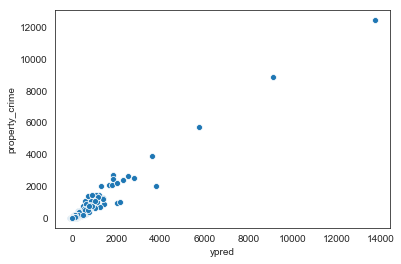

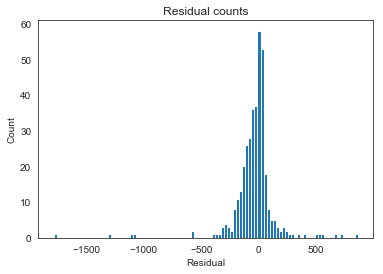

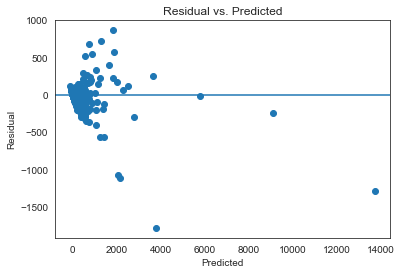

In [29]:
#Score on the 2014ny  data
print('\nR-squared:')
print(regr.score(nyfeatures[['crime','sqrtpop']], nyfeatures['property_crime']))
nyfeatures['ypred'] = regr.predict(nyfeatures[['crime','sqrtpop']]).ravel()
print('\nMean Squared Error:')
print(mean_squared_error(nyfeatures.property_crime,nyfeatures.ypred))




#Basically this data is working terrible for vermont
sns.scatterplot(nyfeatures.ypred,nyfeatures.property_crime)
plt.show()

actual = nyfeatures['property_crime']

# Calculate the error, also called the residual.
predicted = nyfeatures.ypred
residual = actual - predicted

#check multivariate normality
plt.hist(residual, bins=100)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#check scedasticity
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


# Summary for the initial model

In [30]:

print("MODEL:")
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('-'*40)
print("\nTraining Set:")
print('R-squared:')
print(regr.score(features[['crime','sqrtpop']], features['property_crime']))
print('\nMean Squared Error:')
print(mean_squared_error(features['property_crime'],features.ypred))

print('-'*40)
print("\nNY 2014 Set:")
print('R-squared:')
print(regr.score(nyfeatures[['crime','sqrtpop']], nyfeatures['property_crime']))
print('\nMean Squared Error:')
print(mean_squared_error(nyfeatures['property_crime'],nyfeatures.ypred))

print('-'*40)
print("\nVermont 2013 Set:")
print('R-squared:')
print(regr.score(vtfeatures[['crime','sqrtpop']], vtfeatures['property_crime']))
print('\nMean Squared Error:')
print(mean_squared_error(vtfeatures['property_crime'],vtfeatures.ypred))

MODEL:
Coefficients: 
 [-311.72632834    2.95119523]
Intercept: 
 76.7059091067336
----------------------------------------

Training Set:
R-squared:
0.9636910242031071

Mean Squared Error:
38735.72383066401
----------------------------------------

NY 2014 Set:
R-squared:
0.9554933026080367

Mean Squared Error:
40735.879775902366
----------------------------------------

Vermont 2013 Set:
R-squared:
-18.670920144815298

Mean Squared Error:
806163.1877638529


***

___


---

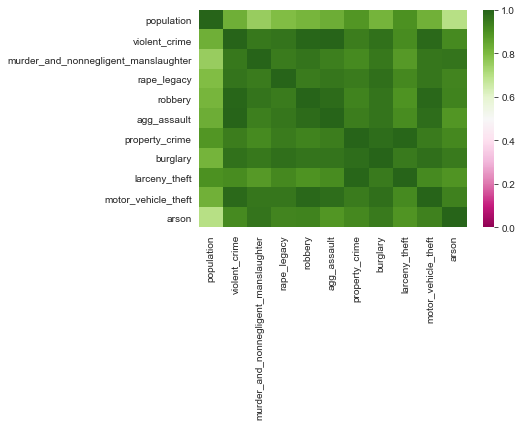

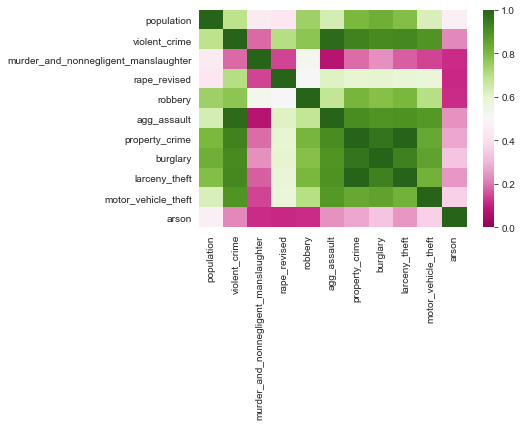

In [31]:
#As we can see below, the data is just fundamentally different. For the scope of NY Data, I'd stick with the above. 
#Below these charts, I try to reduce the model to features that will make the regression more applicable across the 2 states


sns.heatmap(dfny.corr(), vmin=0, cmap="PiYG")
plt.show()
sns.heatmap(vt.corr(), vmin=0, cmap="PiYG")
plt.show()
#sns.heatmap(dftest.corr(), vmin=0, cmap="PiYG")
#plt.show()

# Updated model
This attempt will be similar to the above, but the crime component will use less attributes: specifically, it will use only the crime attributes that are known to be correlated with property crime across both states.

The model will still train on the ny2013 and be tested on vermont13 and ny14.

In [32]:
#Use PCA on several crime items to predict property crime
traincrime = dfny[['violent_crime', 'robbery', 'agg_assault', 'burglary'
             , 'larceny_theft', 'motor_vehicle_theft']]
S = StandardScaler().fit_transform(traincrime)

St = S.T
Cx = np.cov(St)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 6).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)



Eigenvector 1: 
[[-0.41281291]
 [-0.41050708]
 [-0.41083104]
 [-0.41010576]
 [-0.39321671]
 [-0.41168092]]
Eigenvalue 1: 5.815773343207947
----------------------------------------
Eigenvector 2: 
[[ 0.25623671]
 [ 0.33289281]
 [ 0.2257562 ]
 [-0.190365  ]
 [-0.83956025]
 [ 0.17736689]]
Eigenvalue 2: 0.14200353530859758
----------------------------------------
Eigenvector 3: 
[[-0.26205752]
 [ 0.04752654]
 [-0.5611758 ]
 [ 0.60843233]
 [-0.26146653]
 [ 0.41903957]]
Eigenvalue 3: 0.032108637596544
----------------------------------------
Eigenvector 4: 
[[ 0.82356584]
 [-0.33306235]
 [-0.45760899]
 [-0.03706141]
 [ 0.00384266]
 [-0.00380412]]
Eigenvalue 4: 8.637129165884348e-05
----------------------------------------
Eigenvector 5: 
[[ 0.10244181]
 [ 0.65034215]
 [-0.29838276]
 [ 0.18710695]
 [ 0.02604389]
 [-0.66471136]]
Eigenvalue 5: 0.008262449440091774
----------------------------------------
Eigenvector 6: 
[[ 0.08061686]
 [-0.429572  ]
 [ 0.4085284 ]
 [ 0.62370023]
 [-0.26732267]


In [33]:
#96% explained by the first component. Easily keep that one and toss the rest.
P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(St)

#create a new df with the outcome variable and add Y as a feature
features2 = pd.DataFrame(dfny['property_crime'])

features2['crime'] = Y

#Add the root of population, which was also useful per the last assignment
features2['sqrtpop'] = [math.sqrt(x) for x in dfny['population']]

features2.head()

,property_crime,crime,sqrtpop
0,12.0,0.619576,43.139309
1,24.0,0.591604,50.764161
2,16.0,0.603548,53.347915
3,4090.0,-7.159859,312.979233
4,223.0,0.316117,79.924965


In [35]:
regr = linear_model.LinearRegression()
Y = features2['property_crime']
X = features2[['crime','sqrtpop']]
regr.fit(X, Y)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
print('\nMean Squared Error:')
features2['ypred'] = regr.predict(X).ravel()

print(mean_squared_error(features2.property_crime,features2.ypred))


Coefficients: 
 [-365.21369245    2.61692517]

Intercept: 
 111.71033998959467

R-squared:
0.9632897601071995

Mean Squared Error:
39163.80682835549


In [45]:
# Not much performance loss on the training set... let's try it on vermont

In [36]:
#Use PCA on several crime items to predict property crime
vtcrime = vt[['violent_crime', 'robbery', 'agg_assault', 'burglary'
             , 'larceny_theft', 'motor_vehicle_theft']]
S = StandardScaler().fit_transform(vtcrime)

St = S.T
Cx = np.cov(St)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 6).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[[0.42641375]
 [0.36643519]
 [0.41534117]
 [0.41917214]
 [0.41802266]
 [0.40117333]]
Eigenvalue 1: 5.4191728862167
----------------------------------------
Eigenvector 2: 
[[ 0.18007499]
 [-0.84294036]
 [ 0.39811283]
 [-0.01973892]
 [-0.10410322]
 [ 0.29547184]]
Eigenvalue 2: 0.39761129051978056
----------------------------------------
Eigenvector 3: 
[[-0.08100386]
 [ 0.24959145]
 [-0.15420842]
 [-0.24054678]
 [-0.49056614]
 [ 0.78028479]]
Eigenvalue 3: 0.17999749316058966
----------------------------------------
Eigenvector 4: 
[[ 0.73439335]
 [-0.15339926]
 [-0.65873162]
 [-0.02475756]
 [ 0.04781899]
 [ 0.01755373]]
Eigenvalue 4: 0.006758258080580954
----------------------------------------
Eigenvector 5: 
[[-0.45647537]
 [-0.25325663]
 [-0.44883629]
 [ 0.62470812]
 [ 0.23401566]
 [ 0.28462913]]
Eigenvalue 5: 0.11808202225515625
----------------------------------------
Eigenvector 6: 
[[-0.17742415]
 [-0.07218479]
 [-0.09917806]
 [-0.61251054]
 [ 0.71882852]
 [ 0.248

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [37]:
#87% explained by the first component. Easily keep that one and toss the rest.
P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(St)

#create a new df with the outcome variable and add Y as a feature
vtfeat2 = pd.DataFrame(vt['property_crime'])

vtfeat2['crime'] = Y

#Add the root of population, which was also useful per the last assignment
vtfeat2['sqrtpop'] = [math.sqrt(x) for x in vt['population']]

vtfeat2.head()

,property_crime,crime,sqrtpop
0,162.0,-0.534688,89.061776
1,477.0,4.305257,124.466863
2,143.0,0.116849,53.544374
3,64.0,-1.242851,52.697249
4,606.0,5.230206,108.554134


In [38]:
# Inspect the results
Y = vtfeat2['property_crime']
X = vtfeat2[['crime','sqrtpop']]


print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
print('\nMean Squared Error:')
vtfeat2['ypred'] = regr.predict(X).ravel()

print(mean_squared_error(Y,vtfeat2.ypred))


Coefficients: 
 [-365.21369245    2.61692517]

Intercept: 
 111.71033998959467

R-squared:
-23.145793072769962

Mean Squared Error:
989554.5999540425


# Attempt 2

(array([10.,  9.,  4.,  3.,  4.,  1.,  0.,  2.,  1.,  1.]),
 array([ 1110. ,  3018.9,  4927.8,  6836.7,  8745.6, 10654.5, 12563.4,
        14472.3, 16381.2, 18290.1, 20199. ]),
 <a list of 10 Patch objects>)

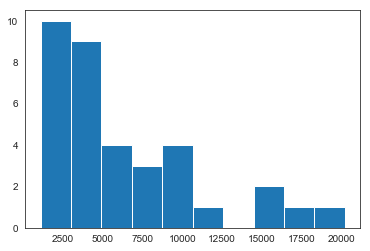

In [39]:
#Vermont's population has less skew, which may be why this model is still a disaster for vermont. Let's try 
#using the crime component by itself
plt.hist(vt.population)

In [40]:
regr = linear_model.LinearRegression()
Y = features2['property_crime']
X = features2[['crime']]
regr.fit(X, Y)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
print('\nMean Squared Error:')
features2['ypred'] = regr.predict(X).ravel()

print(mean_squared_error(features2.property_crime,features2.ypred))


Coefficients: 
 [-417.15636743]

Intercept: 
 385.7521613832853

R-squared:
0.9459194886078149

Mean Squared Error:
57695.038428707856


In [41]:
# Inspect the results for vermont
Y = vtfeat2['property_crime']
X = vtfeat2[['crime']]


print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
print('\nMean Squared Error:')
vtfeat2['ypred'] = regr.predict(X).ravel()

print(mean_squared_error(Y,vtfeat2.ypred))


Coefficients: 
 [-417.15636743]

Intercept: 
 385.7521613832853

R-squared:
-32.75265829327299

Mean Squared Error:
1383267.808770037


In [42]:
#yikes

In [43]:
regr = linear_model.LinearRegression()
Y = features2['property_crime']
X = features2[['sqrtpop']]
regr.fit(X, Y)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
print('\nMean Squared Error:')
features2['ypred'] = regr.predict(X).ravel()

print(mean_squared_error(features2.property_crime,features2.ypred))


Coefficients: 
 [11.04018428]

Intercept: 
 -770.3650413942612

R-squared:
0.5701760390840664

Mean Squared Error:
458551.6908815286


In [44]:
# Inspect the results for vermont
Y = vtfeat2['property_crime']
X = vtfeat2[['sqrtpop']]


print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
print('\nMean Squared Error:')
vtfeat2['ypred'] = regr.predict(X).ravel()

print(mean_squared_error(Y,vtfeat2.ypred))


Coefficients: 
 [11.04018428]

Intercept: 
 -770.3650413942612

R-squared:
-0.11912228198248953

Mean Squared Error:
45864.412020317


# New theory 
The larger city outliers in New York's 2013 (the training set) are skewing all outcomes and ruining any usefulness. 
In this next attempt I'll train the model on only cities smaller than 50K in population, based on the below distribution of the original training data:

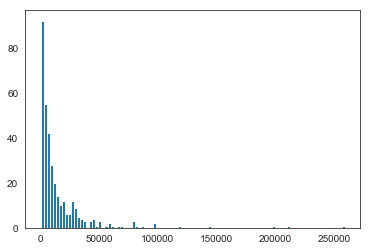

In [48]:
plt.hist(dfny.population, bins=100)
plt.show()

In [50]:
dftrain = dfny[dfny.population<50000]
dftrain.shape

(327, 12)

In [51]:
#Use PCA on several crime items to predict property crime
traincrime = dftrain[['violent_crime', 'robbery', 'agg_assault', 'burglary'
             , 'larceny_theft', 'motor_vehicle_theft']]
S = StandardScaler().fit_transform(traincrime)

St = S.T
Cx = np.cov(St)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 6).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)



Eigenvector 1: 
[[0.42236862]
 [0.41631699]
 [0.41723482]
 [0.41994716]
 [0.36789724]
 [0.40310795]]
Eigenvalue 1: 5.305063672903687
----------------------------------------
Eigenvector 2: 
[[-0.33447407]
 [-0.33932553]
 [-0.34387899]
 [ 0.18538398]
 [ 0.77124725]
 [ 0.15982173]]
Eigenvalue 2: 0.43267602402154953
----------------------------------------
Eigenvector 3: 
[[ 1.78480231e-01]
 [-6.36035177e-04]
 [ 2.28838316e-01]
 [ 1.60157211e-01]
 [ 3.24259402e-01]
 [-8.85992627e-01]]
Eigenvalue 3: 0.1637560990754634
----------------------------------------
Eigenvector 4: 
[[-0.79733062]
 [ 0.28302926]
 [ 0.532231  ]
 [-0.01033989]
 [ 0.02208405]
 [-0.01714233]]
Eigenvalue 4: 0.0008893030074163598
----------------------------------------
Eigenvector 5: 
[[-0.15636148]
 [-0.23837193]
 [-0.07525834]
 [ 0.86434851]
 [-0.40513745]
 [-0.04279471]]
Eigenvalue 5: 0.06365893056752242
----------------------------------------
Eigenvector 6: 
[[ 0.13300983]
 [-0.75803114]
 [ 0.60527822]
 [-0.1281466

In [52]:
#96% explained by the first component. Easily keep that one and toss the rest.
P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(St)

#create a new df with the outcome variable and add Y as a feature
features3 = pd.DataFrame(dftrain['property_crime'])

features3['crime'] = Y

#Add the root of population, which was also useful per the last assignment
features3['sqrtpop'] = [math.sqrt(x) for x in dftrain['population']]

features3.head()

,property_crime,crime,sqrtpop
0,12.0,-1.080962,43.139309
1,24.0,-0.964404,50.764161
2,16.0,-1.018396,53.347915
4,223.0,0.092808,79.924965
5,46.0,-0.861682,63.945289


In [53]:
regr = linear_model.LinearRegression()
Y = features3['property_crime']
X = features3[['crime','sqrtpop']]
regr.fit(X, Y)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
print('\nMean Squared Error:')
features3['ypred'] = regr.predict(X).ravel()

print(mean_squared_error(features3.property_crime,features3.ypred))


Coefficients: 
 [102.60238872   2.12581621]

Intercept: 
 27.93806461625809

R-squared:
0.8682682481151546

Mean Squared Error:
14396.40619895227


In [ ]:
#confirm it's a valid regression still:

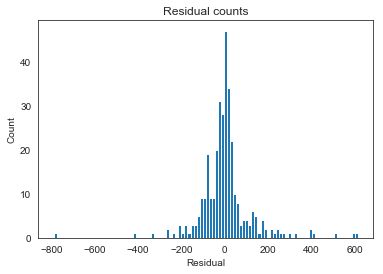

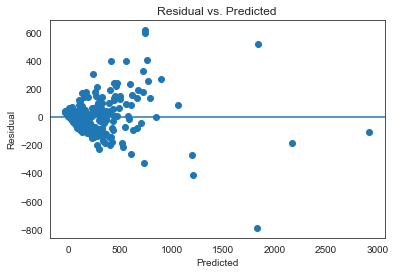

In [58]:
# Calculate the error, also called the residual.
actual = features3.property_crime
predicted = features3.ypred
residual = actual - predicted

#check multivariate normality
plt.hist(residual, bins=100)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#check scedasticity
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


In [54]:
#Try it on vermont

In [55]:
#Use PCA on several crime items to predict property crime
vtcrime = vt[['violent_crime', 'robbery', 'agg_assault', 'burglary'
             , 'larceny_theft', 'motor_vehicle_theft']]
S = StandardScaler().fit_transform(vtcrime)

St = S.T
Cx = np.cov(St)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 6).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[[0.42641375]
 [0.36643519]
 [0.41534117]
 [0.41917214]
 [0.41802266]
 [0.40117333]]
Eigenvalue 1: 5.4191728862167
----------------------------------------
Eigenvector 2: 
[[ 0.18007499]
 [-0.84294036]
 [ 0.39811283]
 [-0.01973892]
 [-0.10410322]
 [ 0.29547184]]
Eigenvalue 2: 0.39761129051978056
----------------------------------------
Eigenvector 3: 
[[-0.08100386]
 [ 0.24959145]
 [-0.15420842]
 [-0.24054678]
 [-0.49056614]
 [ 0.78028479]]
Eigenvalue 3: 0.17999749316058966
----------------------------------------
Eigenvector 4: 
[[ 0.73439335]
 [-0.15339926]
 [-0.65873162]
 [-0.02475756]
 [ 0.04781899]
 [ 0.01755373]]
Eigenvalue 4: 0.006758258080580954
----------------------------------------
Eigenvector 5: 
[[-0.45647537]
 [-0.25325663]
 [-0.44883629]
 [ 0.62470812]
 [ 0.23401566]
 [ 0.28462913]]
Eigenvalue 5: 0.11808202225515625
----------------------------------------
Eigenvector 6: 
[[-0.17742415]
 [-0.07218479]
 [-0.09917806]
 [-0.61251054]
 [ 0.71882852]
 [ 0.248

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [56]:
#87% explained by the first component. Easily keep that one and toss the rest.
P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(St)

#create a new df with the outcome variable and add Y as a feature
vtfeat2 = pd.DataFrame(vt['property_crime'])

vtfeat2['crime'] = Y

#Add the root of population, which was also useful per the last assignment
vtfeat2['sqrtpop'] = [math.sqrt(x) for x in vt['population']]

vtfeat2.head()

,property_crime,crime,sqrtpop
0,162.0,-0.534688,89.061776
1,477.0,4.305257,124.466863
2,143.0,0.116849,53.544374
3,64.0,-1.242851,52.697249
4,606.0,5.230206,108.554134


In [57]:
# Inspect the results
Y = vtfeat2['property_crime']
X = vtfeat2[['crime','sqrtpop']]


print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
print('\nMean Squared Error:')
vtfeat2['ypred'] = regr.predict(X).ravel()

print(mean_squared_error(Y,vtfeat2.ypred))


Coefficients: 
 [102.60238872   2.12581621]

Intercept: 
 27.93806461625809

R-squared:
0.764062825541858

Mean Squared Error:
9669.291689097965


# Much Better. 
Confirm it works on the 2014 NY dataset as well:


In [59]:
#Use PCA on several crime items to predict property crime
nycrime = dftest[['violent_crime', 'robbery', 'agg_assault', 'burglary'
             , 'larceny_theft', 'motor_vehicle_theft']]
S = StandardScaler().fit_transform(nycrime)

St = S.T
Cx = np.cov(St)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 6).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[[-0.41308804]
 [-0.41067897]
 [-0.41002882]
 [-0.41136582]
 [-0.39351526]
 [-0.41048913]]
Eigenvalue 1: 5.8014914085487606
----------------------------------------
Eigenvector 2: 
[[ 0.25350939]
 [ 0.35092583]
 [ 0.2526936 ]
 [-0.17423951]
 [-0.83898747]
 [ 0.1202939 ]]
Eigenvalue 2: 0.14257903152371246
----------------------------------------
Eigenvector 3: 
[[-0.2644628 ]
 [ 0.05545215]
 [-0.58256905]
 [ 0.32197089]
 [-0.20367407]
 [ 0.6651687 ]]
Eigenvalue 3: 0.047400896975429534
----------------------------------------
Eigenvector 4: 
[[-0.83228361]
 [ 0.33447571]
 [ 0.43798758]
 [ 0.05944832]
 [ 0.00776134]
 [-0.00158951]]
Eigenvalue 4: 0.0003817971081816846
----------------------------------------
Eigenvector 5: 
[[ 0.04787158]
 [ 0.58599749]
 [-0.41008926]
 [ 0.38247881]
 [-0.02687202]
 [-0.58234861]]
Eigenvalue 5: 0.004174370230550467
----------------------------------------
Eigenvector 6: 
[[ 0.01276678]
 [ 0.49985182]
 [-0.26197192]
 [-0.73954672]
 [ 0.314611

In [60]:
#87% explained by the first component. Easily keep that one and toss the rest.
P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(St)

#create a new df with the outcome variable and add Y as a feature
nyfeat2 = pd.DataFrame(dftest['property_crime'])

nyfeat2['crime'] = Y

#Add the root of population, which was also useful per the last assignment
nyfeat2['sqrtpop'] = [math.sqrt(x) for x in dftest['population']]

nyfeat2.head()

,property_crime,crime,sqrtpop
0,11.0,0.591468,43.023250
1,49.0,0.551756,50.675438
2,1.0,0.598529,28.635642
3,17.0,0.583856,53.310412
4,3888.0,-7.623769,313.998408


In [63]:
# Inspect the results
Y = nyfeat2['property_crime']
X = nyfeat2[['crime','sqrtpop']]


print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
print('\nMean Squared Error:')
nyfeat2['ypred'] = regr.predict(X).ravel()

print(mean_squared_error(Y,nyfeat2.ypred))


Coefficients: 
 [102.60238872   2.12581621]

Intercept: 
 27.93806461625809

R-squared:
-0.3129487217593754

Mean Squared Error:
1201709.5047625892


Very poorly, though this dataset does include cities that are now out of the scale of this model. Let's see how it performs within our chosen range (<50000 population)

In [64]:
dftest = dftest[dftest.population<50000]

In [65]:
#Use PCA on several crime items to predict property crime
nycrime = dftest[['violent_crime', 'robbery', 'agg_assault', 'burglary'
             , 'larceny_theft', 'motor_vehicle_theft']]
S = StandardScaler().fit_transform(nycrime)

St = S.T
Cx = np.cov(St)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 6).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[[0.42351572]
 [0.41479719]
 [0.4201592 ]
 [0.41794781]
 [0.36468682]
 [0.40542216]]
Eigenvalue 1: 5.297141603339645
----------------------------------------
Eigenvector 2: 
[[-0.2954917 ]
 [-0.32664043]
 [-0.32955991]
 [ 0.22113568]
 [ 0.80461955]
 [ 0.03267021]]
Eigenvalue 2: 0.4203930516646701
----------------------------------------
Eigenvector 3: 
[[ 0.26940471]
 [ 0.20597305]
 [ 0.18441447]
 [-0.11627874]
 [ 0.32478244]
 [-0.85556013]]
Eigenvalue 3: 0.17026605488636812
----------------------------------------
Eigenvector 4: 
[[-0.78025077]
 [ 0.20650586]
 [ 0.58556367]
 [ 0.02944218]
 [ 0.0315449 ]
 [-0.0617846 ]]
Eigenvalue 4: 0.002499396820210213
----------------------------------------
Eigenvector 5: 
[[ 0.21475384]
 [-0.58145531]
 [ 0.52629844]
 [-0.51715674]
 [ 0.19301985]
 [ 0.18464209]]
Eigenvalue 5: 0.035707925557118055
----------------------------------------
Eigenvector 6: 
[[ 0.07635259]
 [-0.54597571]
 [ 0.24692703]
 [ 0.70326379]
 [-0.27541882]
 [-0.2

In [66]:
#87% explained by the first component. Easily keep that one and toss the rest.
P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(St)

#create a new df with the outcome variable and add Y as a feature
nyfeat2 = pd.DataFrame(dftest['property_crime'])

nyfeat2['crime'] = Y

#Add the root of population, which was also useful per the last assignment
nyfeat2['sqrtpop'] = [math.sqrt(x) for x in dftest['population']]

nyfeat2.head()

,property_crime,crime,sqrtpop
0,11.0,-0.978152,43.023250
1,49.0,-0.835440,50.675438
2,1.0,-0.998159,28.635642
3,17.0,-0.953948,53.310412
5,204.0,0.179182,76.628976


In [67]:
# Inspect the results
Y = nyfeat2['property_crime']
X = nyfeat2[['crime','sqrtpop']]


print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
print('\nMean Squared Error:')
nyfeat2['ypred'] = regr.predict(X).ravel()

print(mean_squared_error(Y,nyfeat2.ypred))


Coefficients: 
 [102.60238872   2.12581621]

Intercept: 
 27.93806461625809

R-squared:
0.8392475525538746

Mean Squared Error:
15785.287519867928


# Cross Validation to confirm we haven't overfitted



In [93]:
Y = features3['property_crime']
X = features3[['crime','sqrtpop']]

X_digits = np.array(X)
Y_digits = np.array(Y)

scores = cross_val_score(regr, X_digits, Y_digits, scoring='r2', cv=3,)

# This will print the mean of the list of errors that were output and 
# provide your metric for evaluation
print("NY2013: ",scores)
print("NY2013 mean: ",scores.mean())
print("-"*10)

Y = vtfeat2['property_crime']
X = vtfeat2[['crime','sqrtpop']]
X_digits = np.array(X)
Y_digits = np.array(Y)

scores = cross_val_score(regr, X_digits, Y_digits, scoring='r2', cv=3,)

# This will print the mean of the list of errors that were output and 
# provide your metric for evaluation
print("VT2013: ",scores)
print("VT2013 mean: ",scores.mean())
print("-"*10)



Y = nyfeat2['property_crime']
X = nyfeat2[['crime','sqrtpop']]


X_digits = np.array(X)
Y_digits = np.array(Y)

scores = cross_val_score(regr, X_digits, Y_digits, scoring='r2', cv=3,)

# This will print the mean of the list of errors that were output and 
# provide your metric for evaluation
print("NY2014: ",scores)
print("NY2014 mean: ",scores.mean())

NY2013:  [0.88270738 0.82904286 0.85825615]
NY2013 mean:  0.8566687974182376
----------
VT2013:  [0.95886911 0.94484148 0.65964269]
VT2013 mean:  0.8544510915235692
----------
NY2014:  [0.88757021 0.78699848 0.84973324]
NY2014 mean:  0.8414339729490631


**Vermont is volatile during cross validation because n=35, so taking 3 folds will always be pretty volatile.**

In [94]:
#Use statsmodels to check p values for the parameters

In [95]:
linear_formula = 'property_crime ~ crime+sqrtpop'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=features3).fit()
lm.params

Intercept     27.938065
crime        102.602389
sqrtpop        2.125816
dtype: float64

In [96]:
lm.pvalues

Intercept    1.110479e-01
crime        2.285855e-89
sqrtpop      2.902324e-28
dtype: float64

In [ ]:
#all good

# Summary

- This model is only valid for towns under 50K in population; larger cities will need a different model.
- This linear regression takes 2 features:
    - square root of population
    - a component created using PCA on the count of Violent crimes, robberies, assaults, burglary, larceny, and motor vehicle thefts.